# Basic example on how to run the 'ellipse' fitting tool

The `isophote` package does not provide support for input/output operations. The basic input for the `ellipse` fitting tool is a numpy 2-D array. In this example, we use the `astropy.fits` package to read an image and deliver the required pixel array. The basic output is an instance of class `IsophoteList`. See code documentation for details.

The image of galaxy M51 formerly distributed with the IRAF software as dev$pix was used extensively before as a regression test for the old STSDAS 'ellipse' task. We re-use it here for the sake of consistency.

Note that the M51 galaxy, with its proeminent spiral arms and giant HII regions, is not the best subject for science analysis by the 'ellipse' algorithm, since this algorithm assumes that isophotes are mainly elliptical in shape. On the other hand, the M51 image is ideal for checking the resilience of the algorithm against image contamination by non-elliptical features.

See notebook `Isophote-model/isophote_example3.ipynb`, in which we apply the `ellipse` tool to an image of a "true" elliptical galaxy.

In [1]:
from astropy.io import fits
from astropy.utils.data import download_file

# This was copied from the astropy-tutorials/Contributing.md file,
# but doesn't work (generates a 'unknown url' error).
# tutorialpath = ''
# M51 = download_file(tutorialpath + 'M51.fits', cache=True)
# image = fits.open(M51)
image = fits.open('M51.fits')
pixel_data = image[0].data

Next, we create an instance of the `Ellipse` class, passing the numpy 2-D array with the pixel data as argument to the constructor:

In [2]:
from photutils.isophote.ellipse import Ellipse

ellipse = Ellipse(pixel_data)

Centering on object....   Done. Found x0 = 257.0, y0 = 258.0


Finally, we run the `fit_image` method on the instance, getting as result an instance of class `IsophoteList`.

This may take a while. Wait until all the output prints out, down to the SMA = 0 central intensity value. This interpreted version of the algorithm is significantly slower than the old, compiled code in the IRAF system. In this implementation, we trade speed for flexibility. 

In [3]:
isolist = ellipse.fit_image()

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
  10.00     1070.76 ( 8.38)  0.049 (0.006)  51.18 ( 3.8)  0.190    62     0   50     2
  11.00     1043.49 ( 7.66)  0.129 (0.005)  72.75 ( 1.1)  0.154    65     0   10     0
  12.10      987.31 ( 7.29)  0.154 (0.004)  67.97 ( 0.8)  0.156    70     0   10     0
  13.31      924.67 ( 8.30)  0.154 (0.006)  52.56 ( 1.3)  0.242    77     0   50     2
  14.64      875.32 ( 8.61)  0.154 (0.003)  52.56 ( 0.6)  None     85     0    3     5
  16.11      913.07 ( 8.38)  0.321 (0.005)  52.56 ( 0.5)  0.236    83     0   50     2
  17.72      888.62 ( 8.25)  0.359 (0.003)  50.56 ( 0.3)  0.141    89     0   10     0
  19.49      756.00 ( 7.54)  0.178 (0.002)  35.74 ( 0.4)  0.111   111     0   10     0
  21.4

Check the result's type, it should be an instance of the `IsophoteList` class:

In [4]:
type(isolist)

photutils.isophote.isophote.IsophoteList

Note that the `Ellipse` constructor runs an object centering algorithm. See the `Ellipse` class documentation for details.

### Running 'ellipse' in a finer-grained way:

We can fit individual ellipses as well, by just calling the `fit_isophote` method in the same `Ellipse` instance (passing the semi-major axis length to the method):

In [5]:
isophote = ellipse.fit_isophote(20.)

from photutils.isophote.isophote import print_header
print_header()
print(isophote)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
  20.00      740.53 ( 7.23)  0.192 (0.002)  36.07 ( 0.4)  0.113   113     0   14     0


Note that in this case we get an instance of class `Isophote`, not `IsophoteList` as before:

In [6]:
type(isophote)

photutils.isophote.isophote.Isophote

Regarding the example above, by calling the `fit_isophote` method in a simple `for` loop with successive values for the semi-major axis length, one may be lead to think that it will emulate the behavior of the `fit_image` method. However, that would not in general be the case. The algorithm will probably stop prematurely, and/or will not result in the best fit. The fitting algorithm is quite sensitive to the initial guesses (the starting ellipse geometry) and other fitting parameters such as the step used to move from a given ellipse to the next, the area integration method, finding the maximum acceptable semi-major axis length, and such. The `fit_image` method takes care of handling these details in a transparent way for the user.

In the `isophote` package, the class constructors and method calls accept a variety of parameters that can be used to customize and fine-tune the fit process. Here we give a few examples; please see the code documentation for a complete description. 

For instance, the fit algorithm is quite sensitive to the initial guesses for the `X` and `Y` position of the center of the galaxy on the frame. When using default values as in the examples above, the methods assume that the galaxy is exactly centered in the frame. The fit algorithm can also fail to properly converge if either the ellipticiy or the position angle of the semi-major axis are too way off the true values. To override the default values, we initialize the `Ellipse` constructor with an instance of class `Geometry`. This class encapsulates all data and behavior associated with a given ellipse's geometry.

In [7]:
import numpy as np
from photutils.isophote.geometry import Geometry

# user defines here the geometry parameters that will be used as first guess.
x0 = 256.    # center position
y0 = 256.    # center porsition
sma = 20.    # semi-major axis length in pixels
eps = 0.2    # ellipticity

# positon angle is defined in radians, counterclockwise from the
# +X axis (rotating towards the +Y axis). Here we use 35 degrees 
# as a first guess.
pa = 35. / 180. / np.pi

# note that the Geometry constructor has additional parameters with
# default values. Please see the class documentation for details.
g = Geometry(x0, y0, sma, eps, pa)

# the custom geometry is passed to the Ellipse constructor.
ellipse = Ellipse(pixel_data, geometry=g)

# the fit proceeds as usual.
isophote = ellipse.fit_isophote(20.)

print(isophote)

Centering on object....   Done. Found x0 = 257.0, y0 = 258.0
  20.00      732.58 ( 7.25)  0.183 (0.002)  35.40 ( 0.4)  0.116   114     0   10     0


To further break down the fit process, one could explictly work with the `Sample` and `Fitter` classes, as exemplified below.

In [8]:
from photutils.isophote.sample import Sample
from photutils.isophote.fitter import Fitter

sample = Sample(pixel_data, 7., geometry=g)
fitter = Fitter(sample)
isophote = fitter.fit()

print(isophote)

   7.00     1281.23 ( 8.19)  0.073 (0.005) 120.25 ( 2.2)  0.142    43     0   10     0


In here, we initially create an instance of the `Sample` class. This instance encapsulates everything associated with a given elliptical path over the image. This includes not only the geometry information, but also the raw intensity samples extracted from the image (intensity as a function of polar angle and radius), as well as associated statistical quantities. 

Note that the `Sample` constructor allows for overriding the semi-major axis length initially used to create the `Geometry` instance. That way, one can propagate a given geometry configuration to other Samples taken at other values of semi-major axis length.

The `Sample` instance is used to initialize an instance of the `Fitter` class. This class has a number of controls to help in tweaking the fit. The final result of the `fit` method is an instance of class `Isophote` with the final, fitted values of the geometry parameters.

Raw values extracted from the image can be accessed via the `values` attribute of a `Sample` instance. This attribute stores a 2-D numpy array. The first element is of length 3, and each one of those has as many elements as there are individual extracted values from the image. 

In [9]:
isophote.sample.values.shape

(3, 43)

The 3 top-level elements contain respectively the position angles, the polar radii, and the intensity values extracted at each position along the elliptical path on the image:

In [10]:
# angles in radians
isophote.sample.values[0]

array([ 0.05      ,  0.19288644,  0.3361739 ,  0.48030165,  0.62564106,
        0.7724653 ,  0.92092505,  1.07103245,  1.22265551,  1.37552507,
        1.52925515,  1.68337627,  1.83737888,  1.99076254,  2.14308465,
        2.29400291,  2.44330627,  2.59093146,  2.7369644 ,  2.88162779,
        3.02525777,  3.16827284,  3.31113832,  3.454329  ,  3.59829202,
        3.74341204,  3.88998011,  4.03816824,  4.18801188,  4.33940244,
        4.49209213,  4.64571207,  4.79980367,  4.95386066,  5.10737768,
        5.25989957,  5.41106517,  5.56064049,  5.70853764,  5.85481868,
        5.99968535,  6.14345721,  6.28654166])

In [11]:
# polar radii in pixels
isophote.sample.values[1]

array([ 6.99856493,  6.97897768,  6.93828898,  6.8804462 ,  6.81086458,
        6.73583242,  6.66189686,  6.59530262,  6.54152474,  6.50490772,
        6.48840375,  6.49339629,  6.51959943,  6.56503502,  6.6261035 ,
        6.697773  ,  6.7739114 ,  6.84777004,  6.91259898,  6.96233506,
        6.99227017,  6.99959105,  6.98369509,  6.94622817,  6.89084786,
        6.82276863,  6.7481787 ,  6.67362337,  6.60543142,  6.54923099,
        6.50957146,  6.48964647,  6.49110439,  6.51393557,  6.55643606,
        6.6152615 ,  6.68559519,  6.76145555,  6.83615551,  6.90289931,
        6.95546419,  6.98887927,  6.99999353])

In [12]:
# intensities
isophote.sample.values[2]

array([ 1276.92000884,  1320.60642806,  1337.23605124,  1310.00501376,
        1261.24978973,  1201.54150935,  1162.78485047,  1196.56451538,
        1291.07392577,  1375.52220458,  1409.31442191,  1379.59276368,
        1303.24192573,  1213.4425464 ,  1167.76949733,  1221.93190567,
        1317.10332738,  1336.89856224,  1287.60975105,  1243.15358231,
        1241.53068837,  1275.35792608,  1303.97088288,  1302.67476376,
        1306.29345628,  1271.74844061,  1266.6792211 ,  1271.85831046,
        1285.05966689,  1299.42608522,  1313.89313382,  1307.40961991,
        1276.82117095,  1231.13416971,  1199.11815248,  1230.30523959,
        1291.87760854,  1336.31845105,  1345.3695319 ,  1325.89988559,
        1277.76792777,  1249.15817313,  1269.79706802])

Note that, in the example above, we cannot use the original `Sample` instance that was originally used to initialize the fitter. Once the fitter does its bidding, that instance becomes invalid and we need to look for a new `Sample` instance inside the `Isophote` instance just created by the fitter.

## Plotting results:

Import packages necessary for plotting:

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

The attributes of an `Isophote` instance are also attributes of an `IsophoteList` instance. The difference is, while the individual isophotes have scalar attributes, the same attributes in an `IsophoteList` are numpy arrays that store the given attribute across all isophotes in the list. Thus, attributes in a `IsophoteList` can be directly used as parameters for matplotlib calls.

To ease transition to this new implementation, attribute names were chosen whenever possible to match the names used in the old STSDAS task and its parameter sets.

As an example, a basic plot of magnitude as a function of (semi-major axis length)^1/4 can be done simply as:

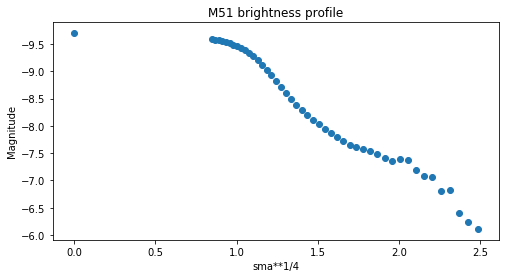

In [14]:
plt.figure(figsize=(8, 4))

plt.scatter(isolist.sma**0.25, -2.5*np.log10(isolist.intens))

plt.xlabel('sma**1/4')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.title("M51 brightness profile")

Next, a multiple plot depicting ellipse geometry as a function of semi-major axis length:

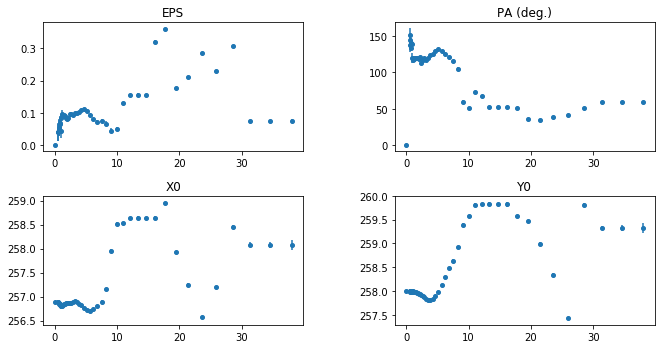

In [15]:
plt.figure(figsize=(10, 5))
plt.figure(1)

plt.subplot(221)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err, fmt='o', markersize=4)
plt.title('EPS')

plt.subplot(222)
plt.errorbar(isolist.sma, isolist.pa/np.pi*180., yerr=isolist.pa_err/np.pi* 80., fmt='o', markersize=4)
plt.title('PA (deg.)')

plt.subplot(223)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o', markersize=4)
plt.title('X0')

plt.subplot(224)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o', markersize=4)
plt.title('Y0')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

Ellipses can be overplotted on the image display:

Closest SMA = 37.974983


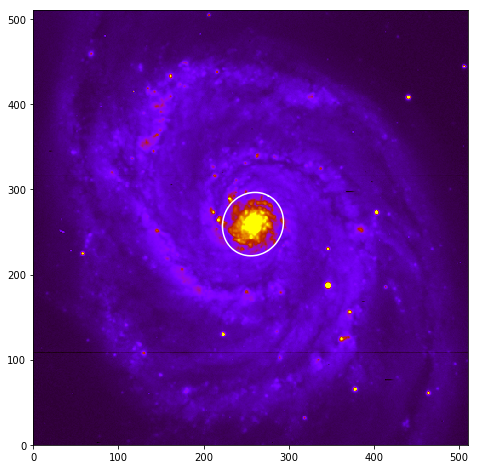

In [16]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(pixel_data, cmap=cm.gnuplot, vmin=0, vmax=1000)
plt.axis([0,511,0,511])

# this method on an IsophoteList instance will retrieve the isophote 
# that has the closest 'sma' from the passed argument.
iso = isolist.get_closest(40.)
print("Closest SMA = %f" % iso.sma)

# this method on an Isophote instance returns the X-Y coordinates of 
# the sampled points in the image.
x, y, = iso.sampled_coordinates()

plt.plot(x, y, color='white')

The "isophote" doesn't look quite isophotal. This is to be expected in this image though. The fitting algorithm assumes that a smooth surface brightness distribution will dominate the image, and this is hardly the case of M51 with its proeminent spiral arms and lots of clumpy star formation regions. 

In another tutorial (`Isophote-model/isophote_example3.ipynb`) we demonstrate the behavior of these algorithms when applied to an image of a true elliptical galaxy.

We can examine the elliptical brightness sample associated with the ellipse depicted above to get an idea of what is going on. The plot below shows large contamination from those bright HII regions.

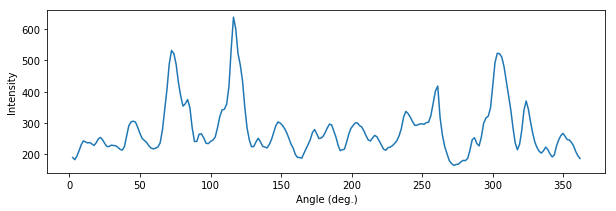

In [17]:
plt.figure(figsize=(10, 3))
plt.plot(iso.sample.values[0]/np.pi*180., iso.sample.values[2])
plt.ylabel("Intensity")
plt.xlabel("Angle (deg.)")

We can use sigma-clipping to try to get around them. Please see the notebook `Isophote-clip/isophote_example2.ipynb` for a demo of the sigma-clip feature.